数据集地址：

http://snap.stanford.edu/node2vec/#datasets

https://github.com/thunlp/OpenNE/tree/master/data/wiki

参考文章：

https://www.cnblogs.com/Lee-yl/p/12670515.html

https://zhuanlan.zhihu.com/p/56380812

In [ ]:
!mkdir wiki
!wget https://github.com/thunlp/OpenNE/raw/master/data/wiki/Wiki_edgelist.txt -O wiki/Wiki_edgelist.txt
!wget https://github.com/thunlp/OpenNE/raw/master/data/wiki/wiki_labels.txt -O wiki/wiki_labels.txt

--2020-06-27 01:51:43--  https://github.com/thunlp/OpenNE/raw/master/data/wiki/Wiki_edgelist.txt
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thunlp/OpenNE/master/data/wiki/Wiki_edgelist.txt [following]
--2020-06-27 01:51:43--  https://raw.githubusercontent.com/thunlp/OpenNE/master/data/wiki/Wiki_edgelist.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162007 (158K) [text/plain]
Saving to: ‘wiki/Wiki_edgelist.txt’

wiki/Wiki_edgelist. 100%[===================>] 158.21K  --.-KB/s    in 0.01s   

2020-06-27 01:51:44 (12.9 MB/s) - ‘wiki/Wiki_edgelist.txt’ saved [162007/162007]

--2020-06-27 01:51

In [ ]:
import networkx as nx
nx.__version__

'2.4'

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
import gensim
gensim.__version__

'3.6.0'

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from gensim.models import Word2Vec
import numpy as np
import itertools
import random

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
random_state = 2020

In [ ]:
G = nx.read_edgelist('./wiki/Wiki_edgelist.txt', create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

# DeepWalk

In [ ]:
class DeepWalk(object):
    def __init__(self, graph, walk_length, num_walks, walkers=1, verbose=0, random_state=None):
        self.G = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.walkers = walkers
        self.verbose = verbose
        self.w2v = None
        self.embeddings = None
        self.random_state = (lambda x: x if x else 2020)(random_state)
        self.dataset = self.get_train_data(self.walk_length, self.num_walks, self.walkers, self.verbose)

    def fit(self, embed_size=128, window=5, n_jobs=3, epochs=5, **kwargs):
        kwargs["sentences"] = self.dataset
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = n_jobs
        kwargs["window"] = window
        kwargs["iter"] = epochs
        kwargs["seed"] = self.random_state

        self.w2v = Word2Vec(**kwargs)
        
    def get_train_data(self, walk_length, num_walks, workers=1, verbose=0):
        if num_walks % workers == 0:
            num_walks = [num_walks//workers]*workers
        else:
            num_walks = [num_walks//workers]*workers + [num_walks % workers]

        nodes = list(self.G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose)(
            delayed(self.simulate_walks)(nodes, num, walk_length) for num in num_walks
        )

        dataset = list(itertools.chain(*results))
        return dataset

    def simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                    walks.append(self.deep_walk(walk_length=walk_length, start_node=v))
        return walks

    def deep_walk(self, walk_length, start_node):

        G = self.G

        walk = [start_node]
        while len(walk) < self.walk_length:
            current_node = walk[-1]
            current_nerghbors = list(G.neighbors(current_node))
            if len(current_nerghbors) > 0:
                walk.append(random.choice(current_nerghbors))
            else:
                break
        return walk

    def get_embeddings(self):
        if self.w2v:
            self.embeddings = {}
            for node in self.G.nodes():
                self.embeddings[node] = self.w2v.wv[node]
            return self.embeddings
        else:
            print("Please train the model first")
            return None

In [ ]:
class Classifier(object):
    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = clf
        self.label_encoder = MultiLabelBinarizer()

    def evaluate(self, y_true, y_pred):
        average_list = ["micro", "macro", "samples", "weighted"]
        results = {}
        y_true = self.label_encoder.transform(y_true)
        y_pred = self.label_encoder.transform(y_pred)
        for average in average_list:
            results[average] = f1_score(y_true, y_pred, average=average)
        return results
        
    def split_train_evaluate(self, X, Y, test_size=0.2, **kwargs):
        X = [self.embeddings[x] for x in X]
        self.label_encoder.fit(Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, **kwargs)
        self.clf.fit(X_train, Y_train)
        y_pred = self.clf.predict(X_test)
        return self.evaluate(Y_test, y_pred)

In [ ]:
def evaluate_embeddings(embeddings, clf, X, Y, **kwargs):
    clf = Classifier(embeddings, clf)
    res = clf.split_train_evaluate(X, Y, **kwargs)
    return res

In [ ]:
def plot_embeddings(X, Y, embeddings,):
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)

    plt.figure(figsize=(15, 10))
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

In [ ]:
X, Y = [], []
with open("./wiki/wiki_labels.txt", "r") as f:
    for line in f:
        x, y = line.split()
        X.append(x)
        Y.append(y)

In [ ]:
model = DeepWalk(G, walk_length=10, num_walks=80, walkers=3, verbose=0, random_state=random_state)
model.fit(embed_size=128, window=5, n_jobs=1, epochs=3)
embeddings = model.get_embeddings()

In [ ]:
clf = LogisticRegression(solver="liblinear", random_state=random_state)
evaluate_embeddings(embeddings, clf, X, Y, test_size=0.2, random_state=random_state)

{'macro': 0.6265443280167758,
 'micro': 0.7484177215189873,
 'samples': 0.7338877338877339,
 'weighted': 0.7454874988747003}

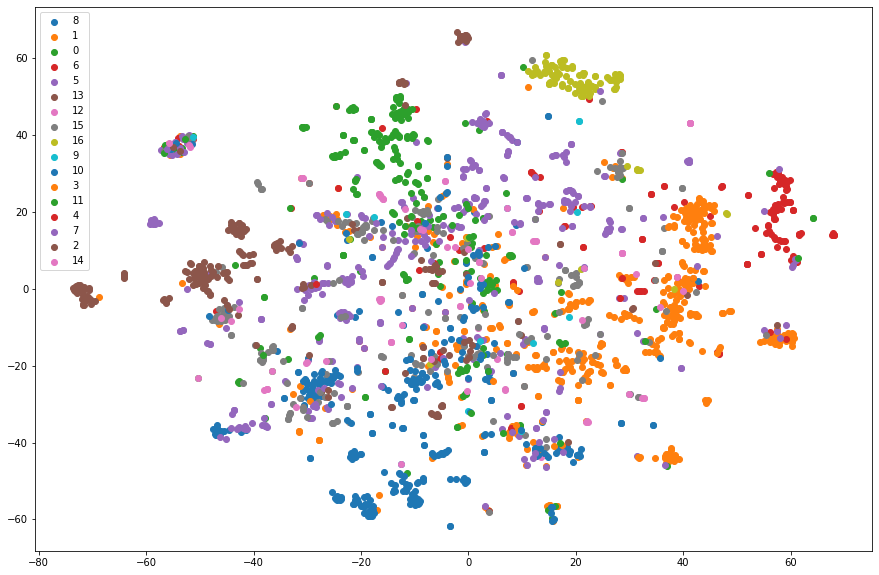

In [ ]:
plot_embeddings(X, Y, embeddings)

# Node2Vec

In [ ]:
def create_alias_table(probs):
    """
    :param probs: sum(probs)=1
    :return: accept,alias
    """
    L = len(probs)
    accept, alias = [0] * L,  [0] * L
    small, large = [], []
    for i, prob in enumerate(probs):
        accept[i] = prob * L
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = probs[small_idx]
        alias[small_idx] = large_idx
        probs[large_idx] = probs[large_idx] - (1 - probs[small_idx])
        if probs[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    return accept, alias


def alias_sample(accept, alias):
    """
    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

In [ ]:
class Node2Vec(object):
    def __init__(self, graph, p, q, walk_length, num_walks, workers=1, verbose=0, random_state=None):
        self.G = graph

        self.p = p
        self.q = q
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.workers = workers
        self.alias_nodes = None
        self.alias_edges = None
        self.verbose = verbose

        self.w2v = None
        self.embeddings = None
        self.random_state = (lambda x: x if x else 2020)(random_state)

        self.preprocess_transition_probs()
        self.dataset = self.get_train_data(self.walk_length, self.num_walks, self.workers, self.verbose)

    def fit(self, embed_size=128, window=5, n_jobs=3, epochs=5, **kwargs):
        kwargs["sentences"] = self.dataset
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 0  # node2vec not use Hierarchical Softmax
        kwargs["workers"] = n_jobs
        kwargs["window"] = window
        kwargs["iter"] = epochs
        kwargs["seed"] = self.random_state

        self.w2v = Word2Vec(**kwargs)

    def get_train_data(self, walk_length, num_walks, workers=1, verbose=0):
        if num_walks % workers == 0:
            num_walks = [num_walks//workers]*workers
        else:
            num_walks = [num_walks//workers]*workers + [num_walks % workers]

        nodes = list(self.G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose)(
            delayed(self.simulate_walks)(nodes, num, walk_length) for num in num_walks
        )

        dataset = list(itertools.chain(*results))
        return dataset

    def simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                    walks.append(self.node2vec_walk(walk_length=walk_length, start_node=v))
        return walks

    def node2vec_walk(self, walk_length, start_node):

        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]
        while len(walk) < self.walk_length:
            current_node = walk[-1]
            current_nerghbors = list(G.neighbors(current_node))
            if len(current_nerghbors) > 0:
                if len(walk) == 1:
                    walk.append(
                        current_nerghbors[alias_sample(alias_nodes[current_node][0], alias_nodes[current_node][1])]
                    )
                else:
                    previous_node = walk[-2]
                    edge = (previous_node, current_node)
                    next_node = current_nerghbors[
                                                    alias_sample(alias_edges[edge][0],   alias_edges[edge][1])
                    ]
                    walk.append(next_node)
            else:
                break
        return walk

    def get_alias_edge(self, t, v):
        """
        2阶随机游走，顶点间的转移概率
        :param t: 上一顶点
        :param v: 当前顶点
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx，无权图权重设为1
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
                            float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

    def preprocess_transition_probs(self):
        """
        在随机游走之前进行初始化
        """
        G = self.G
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [
                                  G[node][nbr].get('weight', 1.0) for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                                float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)

        alias_edges = {}
        for edge in G.edges():
            alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        
        self.alias_edges = alias_edges
        self.alias_nodes = alias_nodes

    def get_embeddings(self):
        if self.w2v:
            self.embeddings = {}
            for node in self.G.nodes():
                self.embeddings[node] = self.w2v.wv[node]
            return self.embeddings
        else:
            print("Please train the model first")
            return None

In [ ]:
model = Node2Vec(G, p=0.25, q=4, walk_length=10, num_walks=80, workers=3, verbose=0, random_state=random_state)
model.fit(embed_size=128, window=5, n_jobs=3, epochs=3)
embeddings = model.get_embeddings()

In [ ]:
clf = LogisticRegression(solver="liblinear", random_state=random_state)
evaluate_embeddings(embeddings, clf, X, Y, test_size=0.2, random_state=random_state)

{'macro': 0.5866502334884606,
 'micro': 0.7265625,
 'samples': 0.7079002079002079,
 'weighted': 0.7232130897580241}

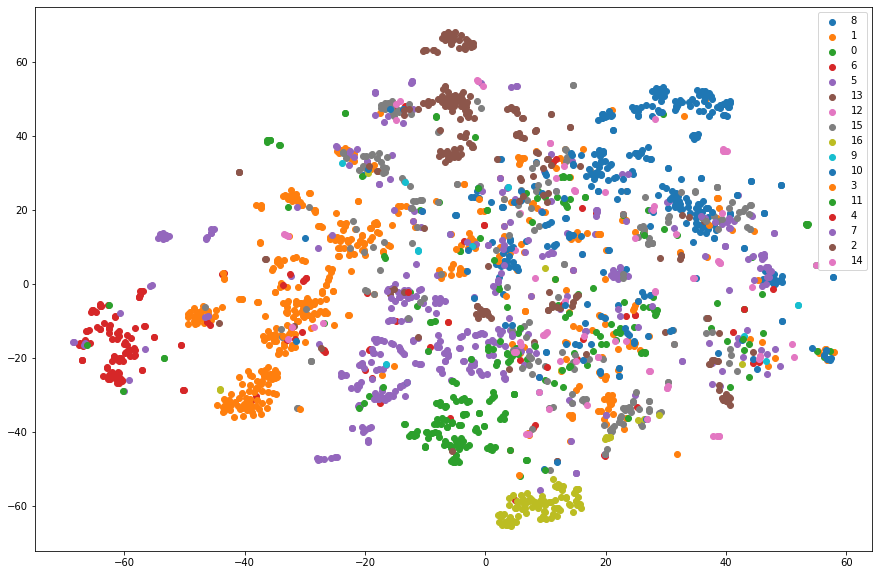

In [ ]:
plot_embeddings(X, Y, embeddings)

In [ ]:
# p=q=1时，Node2Vec就相当于DeepWalk
model = Node2Vec(G, p=1, q=1, walk_length=10, num_walks=80, workers=3, verbose=0, random_state=random_state)
model.fit(embed_size=128, window=5, n_jobs=3, epochs=3)
embeddings = model.get_embeddings()
clf = LogisticRegression(solver="liblinear", random_state=random_state)
evaluate_embeddings(embeddings, clf, X, Y, test_size=0.2, random_state=random_state)

{'macro': 0.6223137164354638,
 'micro': 0.752755905511811,
 'samples': 0.731115731115731,
 'weighted': 0.7499020561287657}

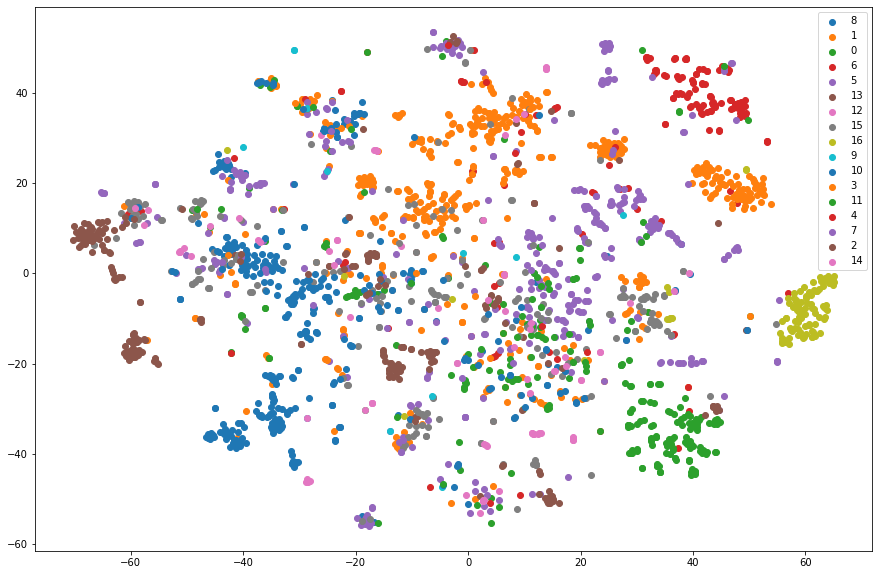

In [ ]:
plot_embeddings(X, Y, embeddings)